# Tabular analysis

Thus far, we've read the data files as output by the National Water Model, which are provided as hourly snapshots in NetCDF format (or slight transformations of them, like via Kerchunk index files or conversion to Zarr).

A subset of the data (we'll look at `reservoir` data) are distributed as NetCDF files but are fundamentally tabular. As an exercise, I [converted](https://github.com/TomAugspurger/noaa-nwm/blob/main/processing/noaanwm.py) some reservoir data to a [geoparquet](https://geoparquet.org/) dataset. Parquet is a nice, high-performance dataset for tabular data.  Geoparquet is like regular parquet, only with some extra geospatial metadata.

In [1]:
import dask.dataframe as dd
import dask_geopandas
import geopandas

This is a pretty large dataset, partitioned across many individual parquet files, so we'll load it up with `dask.dataframe` / `dask-geopandas`.

In [6]:
df = dd.read_parquet(
    "az://ciroh/short-range-reservoir.parquet/",
    storage_options={"account_name": "noaanwm"},
    calculate_divisions=True,
)
geometry = df.geometry.map_partitions(
    geopandas.GeoSeries.from_wkb,
    meta=geopandas.GeoSeries([], name="geometry"),
    crs="epsg:4326",
)

gdf = dask_geopandas.from_dask_dataframe(df, geometry=geometry)
gdf

,feature_id,geometry,reservoir_type,water_sfc_elev,inflow,outflow
npartitions=21,,,,,,
2021-08-26 01:00:00,int32,geometry,category[unknown],float32,float64,float64
2021-09-01 01:00:00,...,...,...,...,...,...
...,...,...,...,...,...,...
2023-04-01 01:00:00,...,...,...,...,...,...
2023-04-18 23:00:00,...,...,...,...,...,...


This data structure shows our 6 columns and their data types.

The output also shows that we have 21 partitions (or individual parquet files). I partitioned the data by month, so we can quickly look up a subset of the data.

In [3]:
w = gdf.loc["2022-07-01":"2022-07-08"]
w.head()

,feature_id,geometry,reservoir_type,water_sfc_elev,inflow,outflow
time,,,,,,
2022-07-01,491,POINT (-68.37904 46.18327),1,206.158081,0.33,0.55
2022-07-01,531,POINT (-68.45489 46.16116),1,247.600632,0.03,0.31
2022-07-01,747,POINT (-68.06499 46.03409),1,190.322128,0.02,0.10
2022-07-01,759,POINT (-68.16213 46.02238),1,165.124863,0.00,0.17
2022-07-01,1581,POINT (-67.93720 45.64844),1,130.030273,0.48,0.55


We can do dataframe-style computations, like grouping by feature ID and getting some summary statistics for the `inflow` variable.

In [4]:
%%time
inflow = (
    df.groupby("feature_id")
    .inflow.agg(["mean", "min", "max", "std", "count"])
    .compute()
)
inflow.head()

CPU times: user 7.49 s, sys: 2.03 s, total: 9.52 s
Wall time: 3.88 s


,mean,min,max,std,count
feature_id,,,,,
491,0.794296,0.07,15.20,1.006294,13236
531,0.342121,0.00,18.43,0.746961,13236
747,0.416411,0.01,14.90,0.815884,13236
759,0.000389,0.00,0.13,0.004175,13236
1581,1.271340,0.37,5.22,1.113017,13236


Let's find the `feature_id` with the largest change in water elevation in the first month.

In [18]:
xs = gdf.get_partition(0).compute()
change = (
    xs.groupby("feature_id")
    .water_sfc_elev.agg(["min", "max"])
    .diff(axis="columns")["max"]
)
feature_id = change.idxmax()
feature_id

22472505

We can get the `geometry` for that feature ID.

In [19]:
from ipyleaflet import Map, CircleMarker


geometry = xs[xs.feature_id == feature_id].iloc[0].geometry
y, x = geometry.y, geometry.x

m = Map(center=(y, x), zoom=15)
m.add(CircleMarker(location=(y, x)))
m.scroll_wheel_zoom = True
m

Map(center=[42.485076904296875, -91.91275787353516], controls=(ZoomControl(options=['position', 'zoom_in_text'…

Now let's examine the timeseries for that particular `feature_id`.

With `dask.dataframe.read_parquet` and pyarrow, we can supply a `filters` argument to efficiently filter the data based on the values, to avoid loading data we don't care about.

In [28]:
ts = df = dd.read_parquet(
    "az://ciroh/short-range-reservoir.parquet/",
    storage_options={"account_name": "noaanwm"},
    calculate_divisions=True,
    filters=[("feature_id", "=", feature_id)],
    columns=["inflow", "outflow", "water_sfc_elev"],
)
ts

,inflow,outflow,water_sfc_elev
npartitions=21,,,
2021-08-26 01:00:00,float64,float64,float32
2021-09-01 01:00:00,...,...,...
...,...,...,...
2023-04-01 01:00:00,...,...,...
2023-04-18 23:00:00,...,...,...


In [29]:
%time ts = ts.compute()

CPU times: user 6 s, sys: 2.07 s, total: 8.08 s
Wall time: 4.39 s


In [30]:
len(ts)

13236

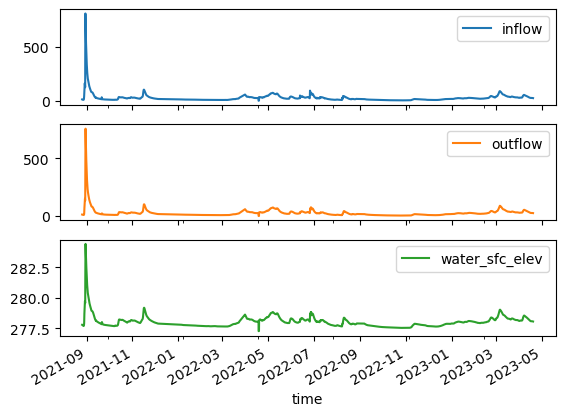

In [31]:
ts.plot(subplots=True);

## Exercise: Explore more

Spend some more time exploring this dataset. The next two cells get the locations where these measurements are taken.

Consider fusing this data with precipitation data from the [noaa-mrms-qpe](https://planetarycomputer.microsoft.com/dataset/noaa-mrms-qpe-24h-pass2) collection, or other products from the [National Water Model](https://planetarycomputer.microsoft.com/dataset/storage/noaa-nwm).

In [32]:
points = xs.groupby("feature_id").geometry.first().set_crs("epsg:4326")
points.head()

feature_id
491     POINT (-68.37904 46.18327)
531     POINT (-68.45489 46.16116)
747     POINT (-68.06499 46.03409)
759     POINT (-68.16213 46.02238)
1581    POINT (-67.93720 45.64844)
Name: geometry, dtype: geometry

In [35]:
# Limit to 1,000 to avoid plotting too many points.
# You can filter spatially with .cx, or look at other subsets
points.head(1000).reset_index().explore()